In [1]:
import numpy as np
import b18_routines as b18
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math

In [2]:
verbose = 1
%config Completer.use_jedi = False  #Speeds up tab autocomplete in notebooks

In [3]:
# Set up input parameters that will be fixed throughout
a_B18_E, b_B18_E, c_B18_E = -1.98, -4402, 0.0 # Exchange

#2 sets of values for dissolution from '16 and '18 papers
a_Mg_B16, b_Mg_B16, c_Mg_B16 = 1.23, -18816.0, 0.0
a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842 , 0.0 # Dissolution - use this for now. 

a_Mg_OS, b_Mg_OS, c_Mg_OS = 0.1,-10851,0.0
a_Si_OS, b_Si_OS, c_Si_OS = 1.3,-13500,0.0  # Fischer 2015
a_O_OS , b_O_OS , c_O_OS  = 0.6,-3800 ,22.0 # Fischer 2015

eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0, -7.4, 9.7, 9.0, 6.1
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                = 0.0, -21.6, 4.6, 0.0

# From the paper
eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0,-17.1, 3.6, 9.0, 4.9
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                = 24.3, -12.2, 4.4, 13.8

In [4]:
# These params may want to change...
Tcmb   = np.linspace(4900,4100,101)

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) #Mass fractions of core O,Si,MgO in mole fractions

XS_c = 0.0000
XC_c = 0.0000
XFe_c= 1-XO_c-XSi_c-XMgO_c
XMgO_m  = 0.5
XFeO_m  = 0.1
XSiO2_m = 1.0 -  XMgO_m - XFeO_m

In [5]:
# Compare logKd values from different studies
logKd_MgO_B16 = b18.logKd_ideal(a_Mg_B16, b_Mg_B16, c_Mg_B16, Tcmb)
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
logKd_MgO_O16 = b18.logKd_ideal(a_Mg_OS , b_Mg_OS , c_Mg_OS , Tcmb)
logKd_MgO_B18E= b18.logKd_ideal(a_B18_E , b_B18_E , c_B18_E , Tcmb)

## Calculate activity coefficients ($\gamma$)

In [7]:
cO_c_niM, cSi_c_niM, cMg_c_niM = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
cO_c_ni , cSi_c_ni , cMg_c_ni  = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
loggammaO, loggammaMg          = np.zeros(len(Tcmb)), np.zeros(len(Tcmb))

params, min_conc = b18.min_conc_closure()

# eps needs to be a YxY symmetric matrix containing coeffs for C, O, Si, S, Mg, ...,. 
X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
eps_C = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S]: \n', X_C)
print('Input eps matrix: \n', eps_C)

lngamma0a = np.array([-0.62,     4.29, -6.65, 0.0, 0.0])
lngamma0b = np.array([-0.00, -16500.0, 0.00 , 0.0, 0.0])

T0 = 1873.0
verb = 0

tt = 0
for t in Tcmb: 
    eps = eps_C * T0 / t                                             # eqn S6
    lngamma0   = lngamma0a + lngamma0b/t
    lngamma0   = lngamma0  * (T0 / t)                                # eqn S5
    lngamma0[1]= lngamma0[1] * t/T0                                  # Do not set 
    lngammaFe  = b18.ln_gamma_Fe(X_C,eps,verb)                       # eqn S3
    lngammai   = b18.ln_gamma_i( X_C,eps, lngammaFe, lngamma0, verb) # eqn S4
    
    loggammaO[tt]  = lngammai[1]/2.303
    loggammaMg[tt] = lngammai[4]/2.303
    
    res = optimize.bisect(min_conc, 0, 0.1, args=(XO_c,XSi_c,XMgO_m,eps,lngamma0,logKd_MgO_B18[tt], t, 1))
    #res = optimize.minimize(min_conc, 0.0, args=(XO_c,XSi_c,XMgO_m,eps,lngamma0,logKd_MgO_B18[tt], t),
    #                        method='BFGS', tol=1e-3)
    
    cO_c_niM[tt], cSi_c_niM[tt], cMg_c_niM[tt] = b18.mole2massconc_core(params['X'][1], params['X'][2], params['X'][4])

    if verbose == 1:
        print('T = {:6.1f} gammaC0 = {:6.4f} gamma_O0 = {:6.4f} gammaSi0 = {:6.4f} gammaS0 = {:6.4f} gammaMg0 = {:6.4f}'
              .format(t,np.exp(lngamma0[0]),np.exp(lngamma0[1]),np.exp(lngamma0[2]), np.exp(lngamma0[3]), np.exp(lngamma0[4])))
        print('T = {:6.1f} gammaC  = {:6.4f} gamma_O  = {:6.4f} gammaSi  = {:6.4f} gammaS  = {:6.4f} gammaMg  = {:6.4f} gammaFe  = {:5.3f}'
          .format(t,np.exp(lngammai[0]),np.exp(lngammai[1]),np.exp(lngammai[2]), np.exp(lngammai[3]),np.exp(lngammai[4]), np.exp(lngammaFe)))
        print('T = {:6.1f} XMg = {:6.4f} XO = {:6.4f} cMg = {:6.4f}'.format(t, params['X'][4], params['X'][1], cMg_c_niM[tt]))
    
    tt = tt + 1

Input mole fractions [C, O, Si, S]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    3.6   4.9  24.3]
 [-20.   -1.   -5.  -17.1 -12.2]
 [  3.6  -5.   12.4   9.    4.4]
 [  4.9 -17.1   9.   -5.7  13.8]
 [ 24.3 -12.2   4.4  13.8   0. ]]
T = 4900.0 gammaC0 = 0.7890 gamma_O0 = 2.5160 gammaSi0 = 0.0787 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4900.0 gammaC  = 0.3996 gamma_O  = 2.1649 gammaSi  = 0.0843 gammaS  = 0.6348 gammaMg  = 0.6938 gammaFe  = 1.006
T = 4900.0 XMg = 0.0096 XO = 0.0950 cMg = 0.0076
T = 4892.0 gammaC0 = 0.7887 gamma_O0 = 2.5021 gammaSi0 = 0.0784 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4892.0 gammaC  = 0.3990 gamma_O  = 2.1525 gammaSi  = 0.0839 gammaS  = 0.6343 gammaMg  = 0.6934 gammaFe  = 1.006
T = 4892.0 XMg = 0.0095 XO = 0.0950 cMg = 0.0076
T = 4884.0 gammaC0 = 0.7884 gamma_O0 = 2.4884 gammaSi0 = 0.0781 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4884.0 gammaC  = 0.3984 gamma_O  = 2.1401 gammaSi  = 0.0836 gammaS  = 0.6339 gammaMg  = 

T = 4644.0 gammaC0 = 0.7788 gamma_O0 = 2.0897 gammaSi0 = 0.0684 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4644.0 gammaC  = 0.3799 gamma_O  = 1.7833 gammaSi  = 0.0735 gammaS  = 0.6191 gammaMg  = 0.6800 gammaFe  = 1.007
T = 4644.0 XMg = 0.0085 XO = 0.0950 cMg = 0.0067
T = 4636.0 gammaC0 = 0.7784 gamma_O0 = 2.0769 gammaSi0 = 0.0681 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4636.0 gammaC  = 0.3792 gamma_O  = 1.7719 gammaSi  = 0.0732 gammaS  = 0.6186 gammaMg  = 0.6795 gammaFe  = 1.007
T = 4636.0 XMg = 0.0084 XO = 0.0950 cMg = 0.0067
T = 4628.0 gammaC0 = 0.7781 gamma_O0 = 2.0642 gammaSi0 = 0.0678 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4628.0 gammaC  = 0.3786 gamma_O  = 1.7606 gammaSi  = 0.0729 gammaS  = 0.6181 gammaMg  = 0.6791 gammaFe  = 1.007
T = 4628.0 XMg = 0.0084 XO = 0.0950 cMg = 0.0067
T = 4620.0 gammaC0 = 0.7777 gamma_O0 = 2.0515 gammaSi0 = 0.0675 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4620.0 gammaC  = 0.3780 gamma_O  = 1.7493 gammaSi  = 0.0726 gammaS  = 0.6176 gammaMg  = 0.6786 gammaFe  =

T = 4372.0 gammaC0 = 0.7667 gamma_O0 = 1.6753 gammaSi0 = 0.0579 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4372.0 gammaC  = 0.3577 gamma_O  = 1.4156 gammaSi  = 0.0625 gammaS  = 0.6009 gammaMg  = 0.6638 gammaFe  = 1.007
T = 4372.0 XMg = 0.0073 XO = 0.0950 cMg = 0.0058
T = 4364.0 gammaC0 = 0.7664 gamma_O0 = 1.6637 gammaSi0 = 0.0576 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4364.0 gammaC  = 0.3570 gamma_O  = 1.4054 gammaSi  = 0.0622 gammaS  = 0.6004 gammaMg  = 0.6633 gammaFe  = 1.007
T = 4364.0 XMg = 0.0073 XO = 0.0950 cMg = 0.0058
T = 4356.0 gammaC0 = 0.7660 gamma_O0 = 1.6522 gammaSi0 = 0.0573 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4356.0 gammaC  = 0.3563 gamma_O  = 1.3953 gammaSi  = 0.0619 gammaS  = 0.5998 gammaMg  = 0.6628 gammaFe  = 1.007
T = 4356.0 XMg = 0.0073 XO = 0.0950 cMg = 0.0058
T = 4348.0 gammaC0 = 0.7656 gamma_O0 = 1.6407 gammaSi0 = 0.0570 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4348.0 gammaC  = 0.3557 gamma_O  = 1.3851 gammaSi  = 0.0616 gammaS  = 0.5992 gammaMg  = 0.6623 gammaFe  =

T = 4116.0 gammaC0 = 0.7542 gamma_O0 = 1.3248 gammaSi0 = 0.0485 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4116.0 gammaC  = 0.3355 gamma_O  = 1.1078 gammaSi  = 0.0526 gammaS  = 0.5822 gammaMg  = 0.6471 gammaFe  = 1.007
T = 4116.0 XMg = 0.0063 XO = 0.0950 cMg = 0.0050
T = 4108.0 gammaC0 = 0.7538 gamma_O0 = 1.3145 gammaSi0 = 0.0482 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4108.0 gammaC  = 0.3348 gamma_O  = 1.0988 gammaSi  = 0.0523 gammaS  = 0.5816 gammaMg  = 0.6466 gammaFe  = 1.007
T = 4108.0 XMg = 0.0063 XO = 0.0950 cMg = 0.0050
T = 4100.0 gammaC0 = 0.7533 gamma_O0 = 1.3042 gammaSi0 = 0.0479 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4100.0 gammaC  = 0.3341 gamma_O  = 1.0898 gammaSi  = 0.0520 gammaS  = 0.5810 gammaMg  = 0.6460 gammaFe  = 1.007
T = 4100.0 XMg = 0.0062 XO = 0.0950 cMg = 0.0049


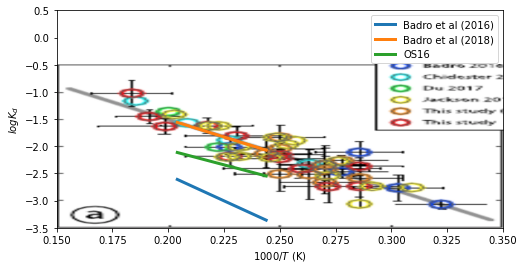

In [8]:
fig, ax1 = plt.subplots(figsize=(8,4))

fischer_a = plt.imread('Fischer_2016_fig6a.png')
fischer_b = plt.imread('Fischer_2016_fig6b.png')
#ax1.imshow(fischer_a, extent=(0.15,0.55,-5,2), aspect='auto') #Plot fischer plot below

badro_1a = plt.imread('badro_18_fig1a.png')
ax1.imshow(badro_1a, extent=(0.15,0.35,-3.5,-0.5), aspect='auto')

ax1.set_ylim([-3.5,0.5]) # Fischer Fig 6
ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$log K_d$")
ax1.set_xlim([0.15,0.35])
ax1.plot(1000.0/Tcmb, logKd_MgO_B16, lw=3, label="Badro et al (2016)")
ax1.plot(1000.0/Tcmb, logKd_MgO_B18, lw=3, label="Badro et al (2018)")
ax1.plot(1000.0/Tcmb, logKd_MgO_O16, lw=3, label="OS16")
ax1.legend()

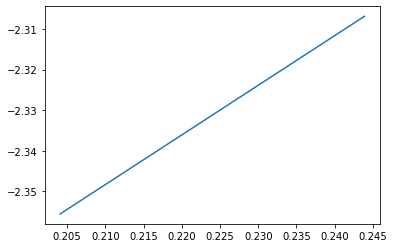

In [10]:
logKD_D19 = b18.D19_exchange(XO_c, XSi_c, Tcmb)
plt.plot(1000.0/Tcmb, logKD_D19)

Note that Figure 6 plots from Fischer 2016 are plotted in the background above

In [11]:
# OS16 and D19 consider exchange
XMg_O16_E  = b18.Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_O16_E, cSi_c_O16_E, cMg_c_O16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_E)
XMg_D19_E  = XFe_c * XMgO_m * 10**(b18.D19_exchange(XO_c, XSi_c, Tcmb)) / XFeO_m
cO_c_D19_E, cSi_c_D19_E, cMg_c_D19_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_D19_E)

# B18 show that dissociation and dissolution are similar so just do the latter. 
XMg_B16_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B16, 0.0, 0.0)
XMg_B18_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_DLi, cSi_c_B16_DLi, cMg_c_B16_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_DLi)
cO_c_B18_DLi, cSi_c_B18_DLi, cMg_c_B18_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_DLi)
cO_c_O16_DLi, cSi_c_O16_DLi, cMg_c_O16_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_DLi)

XMg_B18_DLni  = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,loggammaMg)
XO_c_ni       = XMg_B18_DLni + XO_c                                         # Add O in MgO to core O 
cO_c_B18_DLni, cSi_c_B18_DLni, cMg_c_B18_DLni = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLni)

XMg_B18_DLniMg = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,0.0)
XO_c_niMg      =  XMg_B18_DLniMg + XO_c                                        # Add O in MgO to core O 
cO_c_B18_DLniMg, cSi_c_B18_DLniMg, cMg_c_B18_DLniMg = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLniMg)

# B16 dissolution reaction
XMg_B16 = b18.Mg_dissolution_B16(XMgO_m, 10**logKd_MgO_B16)
cO_c_B16, cSi_c_B16, cMg_c_B16 = b18.mole2massconc_core(0.0, 0.0, XMg_B16)

print('Tcmb        = ', Tcmb[0])
print('\nInput mole fractions:')
display(Math(r'X_O^{{metal}} = {}\\ X_{{Si}}^{{metal}} = {}\\ X_{{MgO}}^{{metal}} = {}\\ X_{{FeO}}^{{metal}} = {}'.format(XO_c, XSi_c, XMgO_c, XFe_c)))

display(Math(r'X_{{MgO}}^{{silicate}} = {}\\'.format(XMgO_m)))
print('a + b/T     = ', logKd_MgO_B18[0])
print('log_gammaO  = ', loggammaO[0])
print('log_gammaMg = ', loggammaMg[0])
display(Math(r'X_{{MgO}}^{{metal}} = {}'.format(XMg_B18_DLni[0])))
print('Which should be the same as:')
print(10**(a_Mg_B18 + b_Mg_B18/Tcmb[0] + np.log10(XMgO_m) - loggammaO[0] - loggammaMg[0]))

Tcmb        =  4900.0

Input mole fractions:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

a + b/T     =  -1.5608163265306123
log_gammaO  =  0.3353822574138986
log_gammaMg =  -0.15873751619468246


<IPython.core.display.Math object>

Which should be the same as:
0.009151850910800684


In [13]:
cO_c_niE, cSi_c_niE, cMg_c_niE = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
loggammaO, loggammaMg          = np.zeros(len(Tcmb)), np.zeros(len(Tcmb))

params, min_conc = b18.min_conc_closure()

eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0,-17.1, 3.6, 9.0, 4.9
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                =  0.0, -18.2, 0.0, 0.0

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) 

X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
eps_C = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S, Mg]: \n', X_C)
print('Input eps matrix: \n', eps_C)

lngamma0a = np.array([-0.62,     4.29, -6.65, 0.0, 0.0])
lngamma0b = np.array([-0.00, -16500.0, 0.00 , 0.0, 0.0])

T0 = 1873.0
verb = 0

tt = 0
for t in Tcmb: 
    eps = eps_C * T0 / t                                             # eqn S6
    lngamma0   = lngamma0a + lngamma0b/t
    lngamma0   = lngamma0  * (T0 / t)                                # eqn S5
    lngamma0[1]= lngamma0[1] * t/T0                                  # Do not set O
    lngammaFe  = b18.ln_gamma_Fe(X_C,eps,verb)                       # eqn S3
    lngammai   = b18.ln_gamma_i( X_C,eps, lngammaFe, lngamma0, verb) # eqn S4
    
    loggammaO[tt]  = lngammai[1]/2.303
    loggammaMg[tt] = lngammai[4]/2.303
    
    res = optimize.bisect(min_conc, 0, 0.1, args=(XO_c,XSi_c,XMgO_m,eps,lngamma0,logKd_MgO_B18E[tt], t, 1))
    
    cO_c_niE[tt], cSi_c_niE[tt], cMg_c_niE[tt] = b18.mole2massconc_core(params['X'][1], params['X'][2], params['X'][4])

    if verbose == 1:
        print('T = {:6.1f} gammaC0 = {:6.4f} gamma_O0 = {:6.4f} gammaSi0 = {:6.4f} gammaS0 = {:6.4f} gammaMg0 = {:6.4f}'
              .format(t,np.exp(lngamma0[0]),np.exp(lngamma0[1]),np.exp(lngamma0[2]), np.exp(lngamma0[3]), np.exp(lngamma0[4])))
        print('T = {:6.1f} gammaC  = {:6.4f} gamma_O  = {:6.4f} gammaSi  = {:6.4f} gammaS  = {:6.4f} gammaMg  = {:6.4f} gammaFe  = {:5.3f}'
          .format(t,np.exp(lngammai[0]),np.exp(lngammai[1]),np.exp(lngammai[2]), np.exp(lngammai[3]),np.exp(lngammai[4]), np.exp(lngammaFe)))
        print('T = {:6.1f} XMg = {:6.4f} XO = {:6.4f} cMg = {:6.4f}'.format(t, params['X'][4], params['X'][1], cMg_c_niE[tt]))
    
    tt = tt + 1

Input mole fractions [C, O, Si, S, Mg]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    3.6   4.9   0. ]
 [-20.   -1.   -5.  -17.1 -18.2]
 [  3.6  -5.   12.4   9.    0. ]
 [  4.9 -17.1   9.   -5.7   0. ]
 [  0.  -18.2   0.    0.    0. ]]
T = 4900.0 gammaC0 = 0.7890 gamma_O0 = 2.5160 gammaSi0 = 0.0787 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4900.0 gammaC  = 0.3996 gamma_O  = 2.1649 gammaSi  = 0.0843 gammaS  = 0.6348 gammaMg  = 0.5023 gammaFe  = 1.006
T = 4900.0 XMg = 0.0006 XO = 0.0950 cMg = 0.0005
T = 4892.0 gammaC0 = 0.7887 gamma_O0 = 2.5021 gammaSi0 = 0.0784 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4892.0 gammaC  = 0.3990 gamma_O  = 2.1525 gammaSi  = 0.0839 gammaS  = 0.6343 gammaMg  = 0.5018 gammaFe  = 1.006
T = 4892.0 XMg = 0.0006 XO = 0.0950 cMg = 0.0005
T = 4884.0 gammaC0 = 0.7884 gamma_O0 = 2.4884 gammaSi0 = 0.0781 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4884.0 gammaC  = 0.3984 gamma_O  = 2.1401 gammaSi  = 0.0836 gammaS  = 0.6339 gammaMg

T = 4636.0 gammaC0 = 0.7784 gamma_O0 = 2.0769 gammaSi0 = 0.0681 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4636.0 gammaC  = 0.3792 gamma_O  = 1.7719 gammaSi  = 0.0732 gammaS  = 0.6186 gammaMg  = 0.4830 gammaFe  = 1.007
T = 4636.0 XMg = 0.0007 XO = 0.0950 cMg = 0.0005
T = 4628.0 gammaC0 = 0.7781 gamma_O0 = 2.0642 gammaSi0 = 0.0678 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4628.0 gammaC  = 0.3786 gamma_O  = 1.7606 gammaSi  = 0.0729 gammaS  = 0.6181 gammaMg  = 0.4824 gammaFe  = 1.007
T = 4628.0 XMg = 0.0007 XO = 0.0950 cMg = 0.0005
T = 4620.0 gammaC0 = 0.7777 gamma_O0 = 2.0515 gammaSi0 = 0.0675 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4620.0 gammaC  = 0.3780 gamma_O  = 1.7493 gammaSi  = 0.0726 gammaS  = 0.6176 gammaMg  = 0.4818 gammaFe  = 1.007
T = 4620.0 XMg = 0.0007 XO = 0.0950 cMg = 0.0005
T = 4612.0 gammaC0 = 0.7774 gamma_O0 = 2.0388 gammaSi0 = 0.0672 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4612.0 gammaC  = 0.3773 gamma_O  = 1.7380 gammaSi  = 0.0722 gammaS  = 0.6171 gammaMg  = 0.4812 gammaFe  =

T = 4340.0 gammaC0 = 0.7652 gamma_O0 = 1.6293 gammaSi0 = 0.0567 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4340.0 gammaC  = 0.3550 gamma_O  = 1.3751 gammaSi  = 0.0613 gammaS  = 0.5987 gammaMg  = 0.4596 gammaFe  = 1.007
T = 4340.0 XMg = 0.0008 XO = 0.0950 cMg = 0.0006
T = 4332.0 gammaC0 = 0.7649 gamma_O0 = 1.6179 gammaSi0 = 0.0564 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4332.0 gammaC  = 0.3543 gamma_O  = 1.3650 gammaSi  = 0.0609 gammaS  = 0.5981 gammaMg  = 0.4590 gammaFe  = 1.007
T = 4332.0 XMg = 0.0008 XO = 0.0950 cMg = 0.0006
T = 4324.0 gammaC0 = 0.7645 gamma_O0 = 1.6065 gammaSi0 = 0.0561 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4324.0 gammaC  = 0.3536 gamma_O  = 1.3550 gammaSi  = 0.0606 gammaS  = 0.5975 gammaMg  = 0.4583 gammaFe  = 1.007
T = 4324.0 XMg = 0.0008 XO = 0.0950 cMg = 0.0006
T = 4316.0 gammaC0 = 0.7641 gamma_O0 = 1.5952 gammaSi0 = 0.0558 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4316.0 gammaC  = 0.3529 gamma_O  = 1.3450 gammaSi  = 0.0603 gammaS  = 0.5970 gammaMg  = 0.4577 gammaFe  =

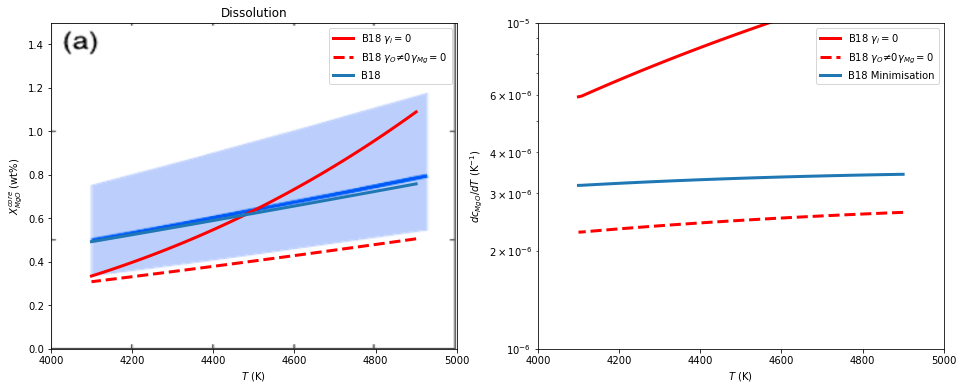

In [14]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(16,6))

badro_4a = plt.imread('badro_18_fig4a.png')
ax2.imshow(badro_4a, extent=(4000,5000,0,1.5), aspect='auto')

ax2.set_title("Dissolution")
ax2.set_xlim([4000,5000])
ax2.set_ylim([0   ,1.5   ])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("$X_{MgO}^{core}$ (wt%)")
ax2.plot(Tcmb, cMg_c_B18_DLi*100   , label="B18 $\gamma_i=0$"                     , color='red', lw=3)
ax2.plot(Tcmb, cMg_c_B18_DLniMg*100, label="B18 $\gamma_O\\ne0 \gamma_{Mg}=0$ "   , color='red',linestyle='--', lw=3)
ax2.plot(Tcmb, cMg_c_niM*100       , label="B18", lw=3)
ax2.legend()

dT = Tcmb[1] - Tcmb[0]
dcMgdT_DLi    = np.gradient(cMg_c_B18_DLi   , dT)
dcMgdT_DLni   = np.gradient(cMg_c_B18_DLni  , dT)
dcMgdT_DLniMg = np.gradient(cMg_c_B18_DLniMg, dT)
dcMgdT_niM    = np.gradient(cMg_c_niM       , dT)
ax3.set_xlim([4000,5000])
ax3.set_ylim([1e-6,1e-5])
ax3.set_yscale('log')
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$dc_{MgO}/dT$ (K$^{-1}$)")
ax3.plot(Tcmb, dcMgdT_DLi   , label="B18 $\gamma_i=0$"                     , color='red', lw=3)
ax3.plot(Tcmb, dcMgdT_DLniMg, label="B18 $\gamma_O\\ne0 \gamma_{Mg}=0$ "   , color='red',linestyle='--', lw=3)
ax3.plot(Tcmb, dcMgdT_niM   , label="B18 Minimisation", lw=3)
ax3.legend()

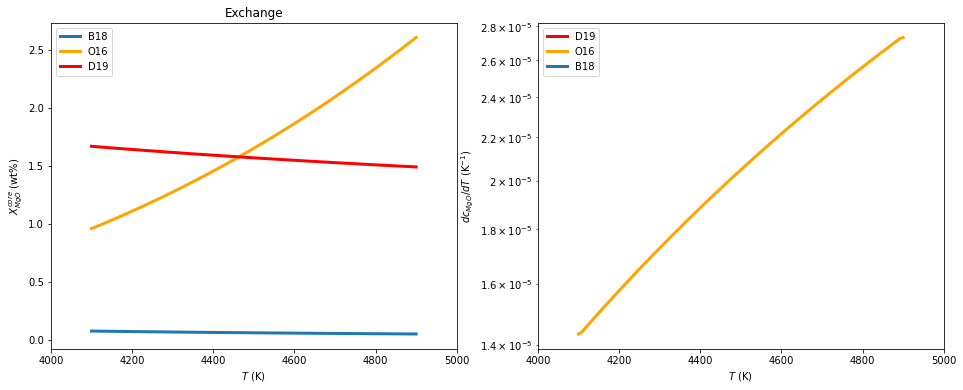

In [15]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(16,6))

ax2.set_title("Exchange")
ax2.set_xlim([4000,5000])
#ax2.set_ylim([0   ,1.5   ])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("$X_{MgO}^{core}$ (wt%)")
ax2.plot(Tcmb, cMg_c_niE*100     , label="B18", lw=3)
ax2.plot(Tcmb, cMg_c_O16_E*100   , label="O16", color='orange', lw=3)
ax2.plot(Tcmb, cMg_c_D19_E*100   , label="D19", color='red'   , lw=3)
ax2.legend()

dT = Tcmb[1] - Tcmb[0]
dcMgdT_B18E = np.gradient(cMg_c_niE  , dT)
dcMgdT_O16E = np.gradient(cMg_c_O16_E, dT)
dcMgdT_D19E = np.gradient(cMg_c_D19_E, dT)
ax3.set_yscale('log')
ax3.set_xlim([4000,5000])
#ax3.set_ylim([1e-6,1e-5])
ax3.set_yscale('log')
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$dc_{MgO}/dT$ (K$^{-1}$)")
ax3.plot(Tcmb, dcMgdT_D19E, label="D19", color='red'   , lw=3)
ax3.plot(Tcmb, dcMgdT_O16E, label="O16", color='orange', lw=3)
ax3.plot(Tcmb, dcMgdT_B18E, label="B18", lw=3)
ax3.legend()